<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/ESAA1129_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 03. 평균 이동
### 평균 이동(Mean Shift)의 개요
평균 이동(Mean Shift)은 K-평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직이면서 군집화를 수행한다. 평균 이동은 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동시킨다. 이를 위해 확률 밀도 함수(probability density function)을 이용하며, 일반적으로 주어진 모델의 확률 밀도 함수를 찾기 위해서 KDE(Kernel Density Estimation)을 사용한다.

평균 이동 군집화는 특정 데이터를 반경 내의 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해 주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤 그 반환 값을 현재 위치에서 업데이트하면서 이동하는 방식을 취한다. 이 과정을 반복적으로 적용한다.
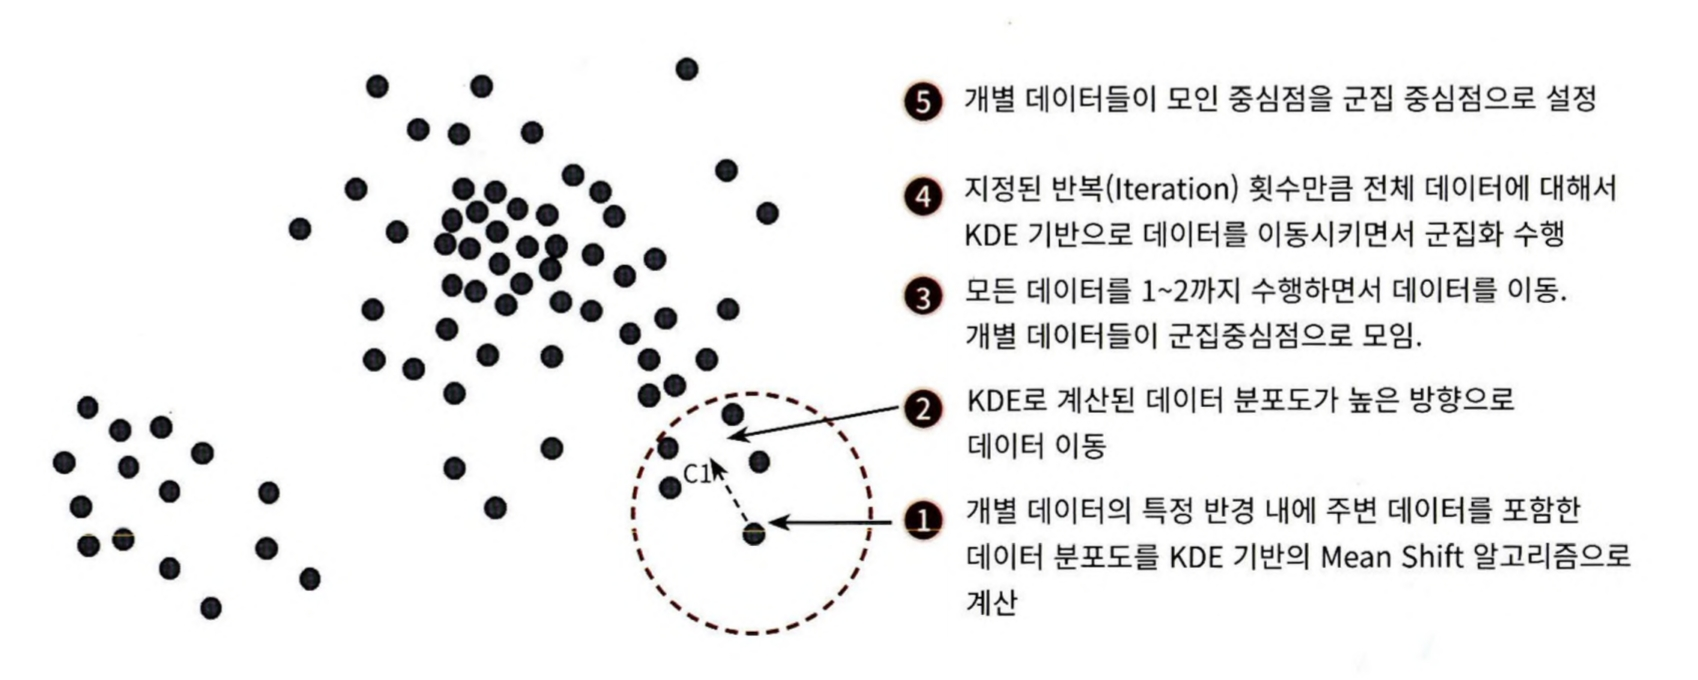


KDE(Kernel Density Estimation)은 커널(Kernel) 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적인 방법이다. 대표적인 커널 함수로서 가우시안 분포 함수가 사용된다.
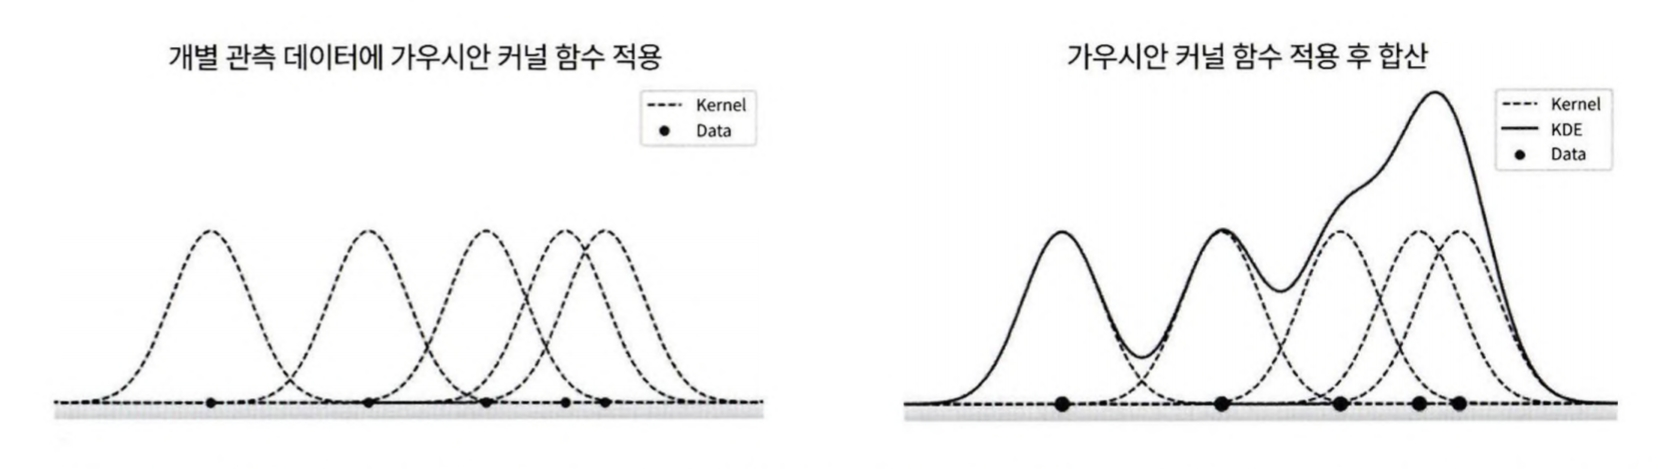

KDE의 커널 함수식에서의 대역폭 h는 평균 이동 군집화에서 매우 중요하다. 일반적으로 평균 이동 군집화는 대역폭이 클수록 평활화된 KDE로 인해 적은 수의 군집 중심점을 가지며, 대역폭이 적을수록 많은 수의 군집 붕심점을 가진다. 사이킷런은 평균 이동 군집화를 위해 MeanShift 클래스를 제공하는데, 이 클래스의 가장 중요한 초기화 파라미터는 bandwidth이며 이 파라미터는 KDE의 대역폭 h와 동일하다.

대역폭 크기 설정이 군집화의 품질에 큰 영향을 미치기 때문에 사이킷런은 최적의 대역폭 계산을 위해 estimate_bandwidth() 함수를 제공한다.

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


지나치게 세분화되어 군집화되었다.

In [ ]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


estimate_bandwidth() 함수 이용.

In [ ]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [ ]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


cluster_centers_속성으로 군집 중심 좌표를 표시해서 시각화

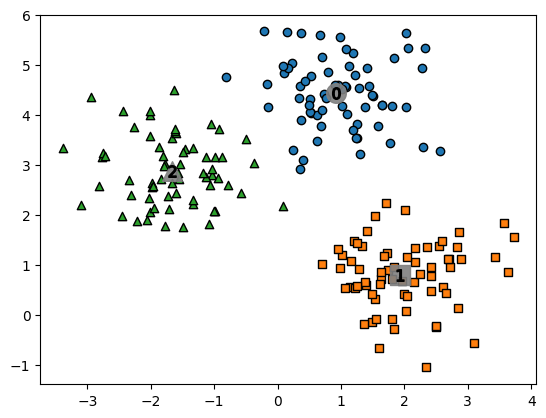

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]

    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [ ]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


장점: 데이터 세트의 형태를 특정 형태로 가정하거나 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화가 가능하다. 이상치의 영향력도 크지 않으며, 미리 군집의 개수를 정할 필요도 없다.

단점: 알고리즘의 수행 시간이 오래 걸린다. 무엇보다도 band_width의 크기에 따른 군집화 영향도가 매우 크다.

## 04. GMM(Gaussian Mixture Model)
### GMM(Gaussian Mixture Model) 소개
GMM 군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포(Gaussian Distribution)를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식이다.

전체 데이터 세트는 서로 다른 정규 분포 형태를 가진 여러가지 확률 분포 곡선으로 구성될 수 있으며, 이러한 서로 다른 정규 분포에 기반에 군집화를 수행하는 것이 GMM 군집화 방식이다. 데이터 세트를 구성하는 여러 개의 정규 분포 곡선을 추출해서 개별 데이터가 이 중 어떤 정규 분포에 속하는지 결정하는 방식이다. GMM에서는 이를 모수 추정이라고 하며 모수 추정은 대표적으로 2가지를 추정하는 것이다.
- 개별 정규 분포의 평균과 분산
- 각 데이터가 어떤 정규 분포에 해당되는지의 확률

사이킷런은 GMM의 EM 방식을 통한 모수 추정 군집화를 지원하기 위해 GaussianMixture 클래스를 지원한다.

### GMM을 이용한 붓꽃 데이터 세트 군집화



In [ ]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

GaussianMixture 객체의 가장 중요한 초기화 파라미터는 n_components이다. n_components는 gaussian mixture의 총 개수이다.

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


### GMM과 K-평균의 비교
KMeans는 원형의 범위에서 군집화를 수행한다. 데이터 세트가 원형의 범위를 가질수록 KMeans의 군집화 효율은 더욱 높아진다.

make_blobs()의 cluster_std를 작게 설정하면 원형 형태로 분산되어서 KMeans로 효과적으로 군집화 된다.

그러나 데이터가 길쭉한 타원형일 때는 군집화를 잘 수행하지 못한다.

아래는 군집을 시각화할 수 있는 visualize_cluster_plot() 함수이다.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    """
    군집화 결과 또는 make_blobs 데이터를 시각화하는 함수

    Parameters:
    - clusterobj: 사이킷런의 군집 수행 객체 (KMeans, GaussianMixture 등). 군집화가 아닌 make_blobs 데이터를 시각화할 경우 None
    - dataframe: 피처 데이터와 레이블을 포함하는 DataFrame
    - label_name: 군집화 결과 레이블 또는 make_blobs 결과 타깃의 칼럼명
    - iscenter: 군집 중심 좌표 시각화 여부 (KMeans 등에서 지원). True일 경우 군집 중심을 표시
    """
    # 산점도 색상 설정
    unique_labels = np.unique(dataframe[label_name])
    colors = sns.color_palette('hsv', len(unique_labels))

    # 군집 중심 좌표
    centers = None
    if iscenter and clusterobj is not None and hasattr(clusterobj, 'cluster_centers_'):
        centers = clusterobj.cluster_centers_

    # 산점도 그리기
    plt.figure(figsize=(10, 7))
    for label, color in zip(unique_labels, colors):
        cluster_data = dataframe[dataframe[label_name] == label]
        plt.scatter(
            cluster_data.iloc[:, 0],  # 첫 번째 피처
            cluster_data.iloc[:, 1],  # 두 번째 피처
            s=50,
            c=[color],
            label=f'Cluster {label}'
        )

    # 군집 중심 좌표 시각화
    if centers is not None:
        plt.scatter(
            centers[:, 0],
            centers[:, 1],
            s=250,
            c='red',
            marker='*',
            label='Centers'
        )

    # 그래프 꾸미기
    plt.title('Cluster Visualization', fontsize=15)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.legend()
    plt.show()

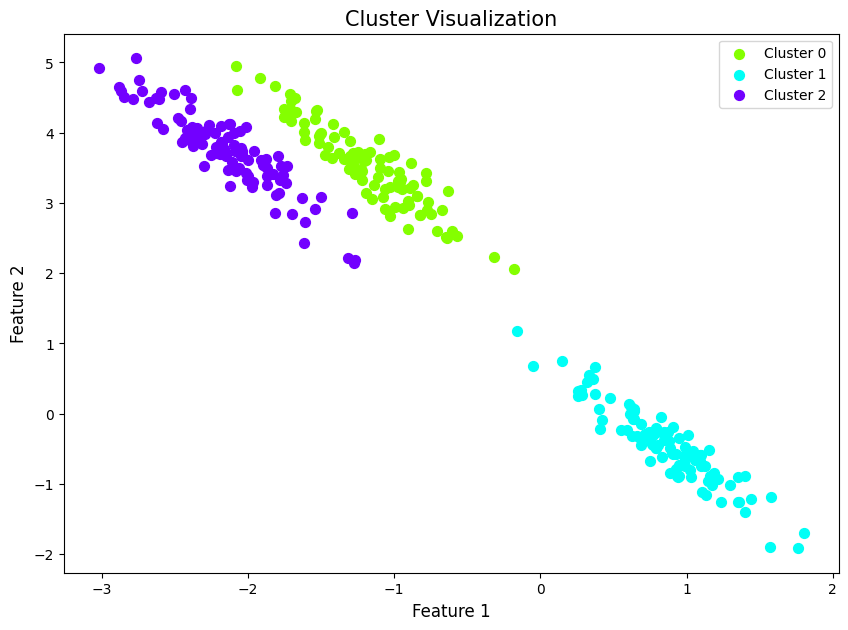

In [ ]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦.
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위해 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.95253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

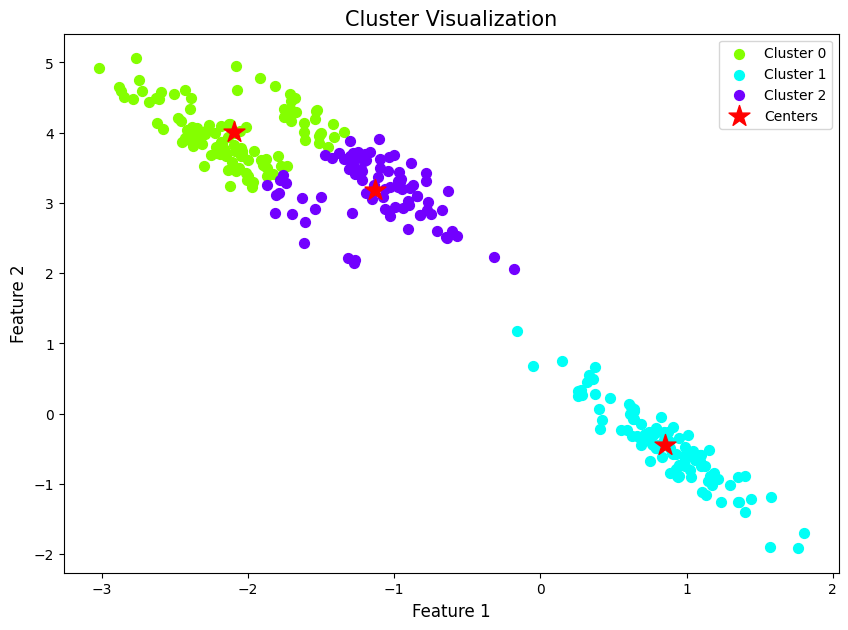

In [ ]:
# 3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

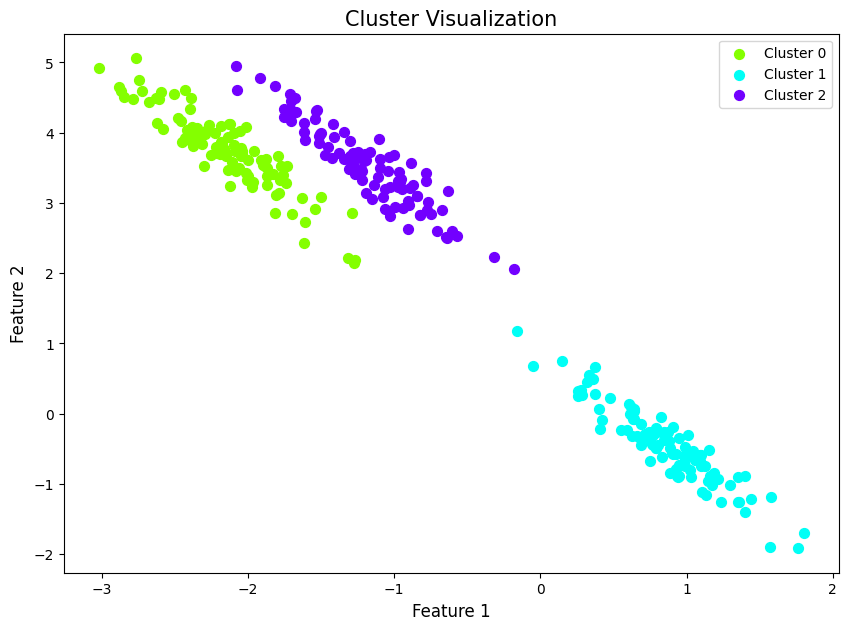

In [17]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [18]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                71
        0                29
1       1               100
2       0                83
        2                17
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64
